## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-05-27 03:10:31--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.109.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.109.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.2’

train-test-data.zip 100%[===================>] 322.93M  82.0MB/s    in 4.1s    

2021-05-27 03:10:35 (78.1 MB/s) - ‘/data/train-test-data.zip.2’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
  (drop1): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose( [Rescale(100) , RandomCrop(96) , Normalize() , ToTensor()] )

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 96, 96])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

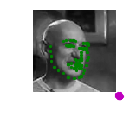

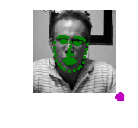

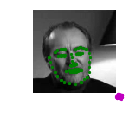

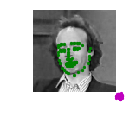

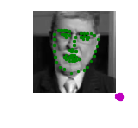

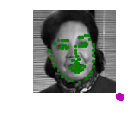

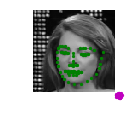

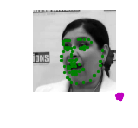

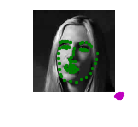

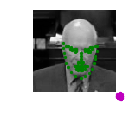

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 30 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.3958116441965103
Epoch: 1, Batch: 20, Avg. Loss: 0.1257889371365309
Epoch: 1, Batch: 30, Avg. Loss: 0.053264730423688886
Epoch: 1, Batch: 40, Avg. Loss: 0.03692342601716518
Epoch: 1, Batch: 50, Avg. Loss: 0.0443960040807724
Epoch: 1, Batch: 60, Avg. Loss: 0.03970242626965046
Epoch: 1, Batch: 70, Avg. Loss: 0.02812441848218441
Epoch: 1, Batch: 80, Avg. Loss: 0.030522856488823892
Epoch: 1, Batch: 90, Avg. Loss: 0.022934899665415287
Epoch: 1, Batch: 100, Avg. Loss: 0.02606023270636797
Epoch: 1, Batch: 110, Avg. Loss: 0.026211587339639665
Epoch: 1, Batch: 120, Avg. Loss: 0.029300078563392163
Epoch: 1, Batch: 130, Avg. Loss: 0.02975010797381401
Epoch: 1, Batch: 140, Avg. Loss: 0.03462198283523321
Epoch: 1, Batch: 150, Avg. Loss: 0.03321513924747706
Epoch: 1, Batch: 160, Avg. Loss: 0.04320407491177321
Epoch: 1, Batch: 170, Avg. Loss: 0.02813576739281416
Epoch: 1, Batch: 180, Avg. Loss: 0.030232470110058786
Epoch: 1, Batch: 190, Avg. Loss: 0.03061627550050616

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.018152325600385665
Epoch: 2, Batch: 20, Avg. Loss: 0.019356247317045928
Epoch: 2, Batch: 30, Avg. Loss: 0.021255976986140013
Epoch: 2, Batch: 40, Avg. Loss: 0.020775745809078216
Epoch: 2, Batch: 50, Avg. Loss: 0.020834370981901884
Epoch: 2, Batch: 60, Avg. Loss: 0.025827198382467033
Epoch: 2, Batch: 70, Avg. Loss: 0.017779937572777273
Epoch: 2, Batch: 80, Avg. Loss: 0.02014434840530157
Epoch: 2, Batch: 90, Avg. Loss: 0.02368633234873414
Epoch: 2, Batch: 100, Avg. Loss: 0.019679547753185034
Epoch: 2, Batch: 110, Avg. Loss: 0.021210314892232417
Epoch: 2, Batch: 120, Avg. Loss: 0.02216540090739727
Epoch: 2, Batch: 130, Avg. Loss: 0.026895413547754286
Epoch: 2, Batch: 140, Avg. Loss: 0.027466582600027323
Epoch: 2, Batch: 150, Avg. Loss: 0.018951030541211368
Epoch: 2, Batch: 160, Avg. Loss: 0.02075920216739178
Epoch: 2, Batch: 170, Avg. Loss: 0.016494450345635413
Epoch: 2, Batch: 180, Avg. Loss: 0.02091123815625906
Epoch: 2, Batch: 190, Avg. Loss: 0.0160455

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.011905511934310197
Epoch: 3, Batch: 20, Avg. Loss: 0.013830634718760847
Epoch: 3, Batch: 30, Avg. Loss: 0.01285482500679791
Epoch: 3, Batch: 40, Avg. Loss: 0.018836415279656647
Epoch: 3, Batch: 50, Avg. Loss: 0.015319486334919929
Epoch: 3, Batch: 60, Avg. Loss: 0.01293842839077115
Epoch: 3, Batch: 70, Avg. Loss: 0.013229890633374453
Epoch: 3, Batch: 80, Avg. Loss: 0.012759750708937645
Epoch: 3, Batch: 90, Avg. Loss: 0.01195826856419444
Epoch: 3, Batch: 100, Avg. Loss: 0.014293734403327107
Epoch: 3, Batch: 110, Avg. Loss: 0.020008162409067155
Epoch: 3, Batch: 120, Avg. Loss: 0.014850718295201659
Epoch: 3, Batch: 130, Avg. Loss: 0.012941623851656914
Epoch: 3, Batch: 140, Avg. Loss: 0.01241112444549799
Epoch: 3, Batch: 150, Avg. Loss: 0.012934728991240263
Epoch: 3, Batch: 160, Avg. Loss: 0.01647822055965662
Epoch: 3, Batch: 170, Avg. Loss: 0.011509129591286183
Epoch: 3, Batch: 180, Avg. Loss: 0.010402745800092816
Epoch: 3, Batch: 190, Avg. Loss: 0.0136808

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.016370004788041116
Epoch: 4, Batch: 20, Avg. Loss: 0.014500746596604585
Epoch: 4, Batch: 30, Avg. Loss: 0.00888543389737606
Epoch: 4, Batch: 40, Avg. Loss: 0.012057566782459617
Epoch: 4, Batch: 50, Avg. Loss: 0.010592794604599476
Epoch: 4, Batch: 60, Avg. Loss: 0.01728572668507695
Epoch: 4, Batch: 70, Avg. Loss: 0.011057297606021166
Epoch: 4, Batch: 80, Avg. Loss: 0.00979059119708836
Epoch: 4, Batch: 90, Avg. Loss: 0.01698976047337055
Epoch: 4, Batch: 100, Avg. Loss: 0.011091447109356523
Epoch: 4, Batch: 110, Avg. Loss: 0.010632257536053657
Epoch: 4, Batch: 120, Avg. Loss: 0.010199737921357154
Epoch: 4, Batch: 130, Avg. Loss: 0.009315842809155584
Epoch: 4, Batch: 140, Avg. Loss: 0.010161545779556035
Epoch: 4, Batch: 150, Avg. Loss: 0.010082678543403745
Epoch: 4, Batch: 160, Avg. Loss: 0.01004121801815927
Epoch: 4, Batch: 170, Avg. Loss: 0.017146930750459432
Epoch: 4, Batch: 180, Avg. Loss: 0.008601805474609137
Epoch: 4, Batch: 190, Avg. Loss: 0.0137444

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.010269093047827482
Epoch: 5, Batch: 20, Avg. Loss: 0.009844632307067513
Epoch: 5, Batch: 30, Avg. Loss: 0.008168880105949938
Epoch: 5, Batch: 40, Avg. Loss: 0.006998119386844337
Epoch: 5, Batch: 50, Avg. Loss: 0.010338044934906065
Epoch: 5, Batch: 60, Avg. Loss: 0.00675288219936192
Epoch: 5, Batch: 70, Avg. Loss: 0.008529279194772244
Epoch: 5, Batch: 80, Avg. Loss: 0.013333612121641636
Epoch: 5, Batch: 90, Avg. Loss: 0.013655603304505349
Epoch: 5, Batch: 100, Avg. Loss: 0.009477709420025349
Epoch: 5, Batch: 110, Avg. Loss: 0.009997031139209866
Epoch: 5, Batch: 120, Avg. Loss: 0.007642807369120419
Epoch: 5, Batch: 130, Avg. Loss: 0.009217921551316977
Epoch: 5, Batch: 140, Avg. Loss: 0.007796225254423916
Epoch: 5, Batch: 150, Avg. Loss: 0.011160827567800879
Epoch: 5, Batch: 160, Avg. Loss: 0.008762152399867773
Epoch: 5, Batch: 170, Avg. Loss: 0.01002681921236217
Epoch: 5, Batch: 180, Avg. Loss: 0.008306246809661388
Epoch: 5, Batch: 190, Avg. Loss: 0.0098

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.011318009998649358
Epoch: 6, Batch: 20, Avg. Loss: 0.010971770435571671
Epoch: 6, Batch: 30, Avg. Loss: 0.00865749423392117
Epoch: 6, Batch: 40, Avg. Loss: 0.007952226791530848
Epoch: 6, Batch: 50, Avg. Loss: 0.007522116973996162
Epoch: 6, Batch: 60, Avg. Loss: 0.007180097280070186
Epoch: 6, Batch: 70, Avg. Loss: 0.010385482013225556
Epoch: 6, Batch: 80, Avg. Loss: 0.008196955593302847
Epoch: 6, Batch: 90, Avg. Loss: 0.008948620734736323
Epoch: 6, Batch: 100, Avg. Loss: 0.007683151727542281
Epoch: 6, Batch: 110, Avg. Loss: 0.009299034485593438
Epoch: 6, Batch: 120, Avg. Loss: 0.008189574722200632
Epoch: 6, Batch: 130, Avg. Loss: 0.007718193670734763
Epoch: 6, Batch: 140, Avg. Loss: 0.006598419812507928
Epoch: 6, Batch: 150, Avg. Loss: 0.00915940385311842
Epoch: 6, Batch: 160, Avg. Loss: 0.008095688791945577
Epoch: 6, Batch: 170, Avg. Loss: 0.006635267660021782
Epoch: 6, Batch: 180, Avg. Loss: 0.009554072143509984
Epoch: 6, Batch: 190, Avg. Loss: 0.0106

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.007463479274883866
Epoch: 7, Batch: 20, Avg. Loss: 0.006349572981707752
Epoch: 7, Batch: 30, Avg. Loss: 0.005944291595369577
Epoch: 7, Batch: 40, Avg. Loss: 0.0062043600715696815
Epoch: 7, Batch: 50, Avg. Loss: 0.006242502806708216
Epoch: 7, Batch: 60, Avg. Loss: 0.007683125673793256
Epoch: 7, Batch: 70, Avg. Loss: 0.00945377852767706
Epoch: 7, Batch: 80, Avg. Loss: 0.008842526795342564
Epoch: 7, Batch: 90, Avg. Loss: 0.00860030371695757
Epoch: 7, Batch: 100, Avg. Loss: 0.00703792585991323
Epoch: 7, Batch: 110, Avg. Loss: 0.00836583604104817
Epoch: 7, Batch: 120, Avg. Loss: 0.0063386176712811
Epoch: 7, Batch: 130, Avg. Loss: 0.006553550064563751
Epoch: 7, Batch: 140, Avg. Loss: 0.007629931159317494
Epoch: 7, Batch: 150, Avg. Loss: 0.006226955680176616
Epoch: 7, Batch: 160, Avg. Loss: 0.006570355081930756
Epoch: 7, Batch: 170, Avg. Loss: 0.005402980581857264
Epoch: 7, Batch: 180, Avg. Loss: 0.007186723500490188
Epoch: 7, Batch: 190, Avg. Loss: 0.0088104

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.00631282664835453
Epoch: 8, Batch: 20, Avg. Loss: 0.004603863949887455
Epoch: 8, Batch: 30, Avg. Loss: 0.006517857313156128
Epoch: 8, Batch: 40, Avg. Loss: 0.007049219729378819
Epoch: 8, Batch: 50, Avg. Loss: 0.010260096611455083
Epoch: 8, Batch: 60, Avg. Loss: 0.005968133313581347
Epoch: 8, Batch: 70, Avg. Loss: 0.010956802545115352
Epoch: 8, Batch: 80, Avg. Loss: 0.00780106564052403
Epoch: 8, Batch: 90, Avg. Loss: 0.015159352263435722
Epoch: 8, Batch: 100, Avg. Loss: 0.010368386190384627
Epoch: 8, Batch: 110, Avg. Loss: 0.006573945633135736
Epoch: 8, Batch: 120, Avg. Loss: 0.00761718899011612
Epoch: 8, Batch: 130, Avg. Loss: 0.009467718657106161
Epoch: 8, Batch: 140, Avg. Loss: 0.006280218833126128
Epoch: 8, Batch: 150, Avg. Loss: 0.007386209629476071
Epoch: 8, Batch: 160, Avg. Loss: 0.0053504850715398785
Epoch: 8, Batch: 170, Avg. Loss: 0.006864177854731679
Epoch: 8, Batch: 180, Avg. Loss: 0.009215142065659165
Epoch: 8, Batch: 190, Avg. Loss: 0.0094

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.006632376788184046
Epoch: 9, Batch: 20, Avg. Loss: 0.006524573429487646
Epoch: 9, Batch: 30, Avg. Loss: 0.008274680655449628
Epoch: 9, Batch: 40, Avg. Loss: 0.005987930507399142
Epoch: 9, Batch: 50, Avg. Loss: 0.006194437015801668
Epoch: 9, Batch: 60, Avg. Loss: 0.014351556729525327
Epoch: 9, Batch: 70, Avg. Loss: 0.006145888846367598
Epoch: 9, Batch: 80, Avg. Loss: 0.0068391464883461595
Epoch: 9, Batch: 90, Avg. Loss: 0.006194959068670869
Epoch: 9, Batch: 100, Avg. Loss: 0.00542837199755013
Epoch: 9, Batch: 110, Avg. Loss: 0.007910972274839879
Epoch: 9, Batch: 120, Avg. Loss: 0.005790512450039387
Epoch: 9, Batch: 130, Avg. Loss: 0.005900569609366357
Epoch: 9, Batch: 140, Avg. Loss: 0.012758085946552455
Epoch: 9, Batch: 150, Avg. Loss: 0.005849549896083772
Epoch: 9, Batch: 160, Avg. Loss: 0.005530081246979535
Epoch: 9, Batch: 170, Avg. Loss: 0.007870159321464598
Epoch: 9, Batch: 180, Avg. Loss: 0.0056877491064369675
Epoch: 9, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.007085493532940745
Epoch: 10, Batch: 20, Avg. Loss: 0.004731534956954419
Epoch: 10, Batch: 30, Avg. Loss: 0.006647489941678941
Epoch: 10, Batch: 40, Avg. Loss: 0.005912109138444066
Epoch: 10, Batch: 50, Avg. Loss: 0.007330232835374773
Epoch: 10, Batch: 60, Avg. Loss: 0.005873491405509412
Epoch: 10, Batch: 70, Avg. Loss: 0.007650372129864991
Epoch: 10, Batch: 80, Avg. Loss: 0.006422866974025965
Epoch: 10, Batch: 90, Avg. Loss: 0.0068572361022233965
Epoch: 10, Batch: 100, Avg. Loss: 0.005401683761738241
Epoch: 10, Batch: 110, Avg. Loss: 0.005870734015479684
Epoch: 10, Batch: 120, Avg. Loss: 0.004881661245599389
Epoch: 10, Batch: 130, Avg. Loss: 0.0059857906075194475
Epoch: 10, Batch: 140, Avg. Loss: 0.005319877224974334
Epoch: 10, Batch: 150, Avg. Loss: 0.005851682624779642
Epoch: 10, Batch: 160, Avg. Loss: 0.005892595322802663
Epoch: 10, Batch: 170, Avg. Loss: 0.008492713887244463
Epoch: 10, Batch: 180, Avg. Loss: 0.005023540277034044
Epoch: 10, Batch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.009469698509201407
Epoch: 11, Batch: 20, Avg. Loss: 0.005565182515420019
Epoch: 11, Batch: 30, Avg. Loss: 0.006515564164146781
Epoch: 11, Batch: 40, Avg. Loss: 0.005820349673740566
Epoch: 11, Batch: 50, Avg. Loss: 0.0049947472522035245
Epoch: 11, Batch: 60, Avg. Loss: 0.004462682013399899
Epoch: 11, Batch: 70, Avg. Loss: 0.005891538597643376
Epoch: 11, Batch: 80, Avg. Loss: 0.005956035712733865
Epoch: 11, Batch: 90, Avg. Loss: 0.008441167324781418
Epoch: 11, Batch: 100, Avg. Loss: 0.005688551068305969
Epoch: 11, Batch: 110, Avg. Loss: 0.005022103106603027
Epoch: 11, Batch: 120, Avg. Loss: 0.005801012553274631
Epoch: 11, Batch: 130, Avg. Loss: 0.006365088187158108
Epoch: 11, Batch: 140, Avg. Loss: 0.006771979038603604
Epoch: 11, Batch: 150, Avg. Loss: 0.007236344064585865
Epoch: 11, Batch: 160, Avg. Loss: 0.006697171973064542
Epoch: 11, Batch: 170, Avg. Loss: 0.004952891310676932
Epoch: 11, Batch: 180, Avg. Loss: 0.005161095061339438
Epoch: 11, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.00621737337205559
Epoch: 12, Batch: 20, Avg. Loss: 0.006582230608910322
Epoch: 12, Batch: 30, Avg. Loss: 0.004297148808836937
Epoch: 12, Batch: 40, Avg. Loss: 0.0058421907015144825
Epoch: 12, Batch: 50, Avg. Loss: 0.0059560992987826465
Epoch: 12, Batch: 60, Avg. Loss: 0.00496668613050133
Epoch: 12, Batch: 70, Avg. Loss: 0.004601790499873459
Epoch: 12, Batch: 80, Avg. Loss: 0.0046201070537790654
Epoch: 12, Batch: 90, Avg. Loss: 0.0051026024855673315
Epoch: 12, Batch: 100, Avg. Loss: 0.011044886242598296
Epoch: 12, Batch: 110, Avg. Loss: 0.0068428212543949485
Epoch: 12, Batch: 120, Avg. Loss: 0.005962276156060398
Epoch: 12, Batch: 130, Avg. Loss: 0.004758737445808947
Epoch: 12, Batch: 140, Avg. Loss: 0.005036792694590985
Epoch: 12, Batch: 150, Avg. Loss: 0.004667568765580654
Epoch: 12, Batch: 160, Avg. Loss: 0.004609773773699999
Epoch: 12, Batch: 170, Avg. Loss: 0.005581588740460575
Epoch: 12, Batch: 180, Avg. Loss: 0.005193058587610722
Epoch: 12, Batch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.006866825022734701
Epoch: 13, Batch: 20, Avg. Loss: 0.005095777870155871
Epoch: 13, Batch: 30, Avg. Loss: 0.005682991957291961
Epoch: 13, Batch: 40, Avg. Loss: 0.006797365914098919
Epoch: 13, Batch: 50, Avg. Loss: 0.005809648055583238
Epoch: 13, Batch: 60, Avg. Loss: 0.00580579242669046
Epoch: 13, Batch: 70, Avg. Loss: 0.004379683127626777
Epoch: 13, Batch: 80, Avg. Loss: 0.005259694461710751
Epoch: 13, Batch: 90, Avg. Loss: 0.005645584827288985
Epoch: 13, Batch: 100, Avg. Loss: 0.005533116403967142
Epoch: 13, Batch: 110, Avg. Loss: 0.004869124549441039
Epoch: 13, Batch: 120, Avg. Loss: 0.005207437858916819
Epoch: 13, Batch: 130, Avg. Loss: 0.004322522087022662
Epoch: 13, Batch: 140, Avg. Loss: 0.0056724158814176915
Epoch: 13, Batch: 150, Avg. Loss: 0.004596880078315735
Epoch: 13, Batch: 160, Avg. Loss: 0.005835250345990061
Epoch: 13, Batch: 170, Avg. Loss: 0.011916690785437823
Epoch: 13, Batch: 180, Avg. Loss: 0.004575977590866387
Epoch: 13, Batch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.007240044232457876
Epoch: 14, Batch: 20, Avg. Loss: 0.006457810872234404
Epoch: 14, Batch: 30, Avg. Loss: 0.0057841029716655615
Epoch: 14, Batch: 40, Avg. Loss: 0.005798559496179223
Epoch: 14, Batch: 50, Avg. Loss: 0.005099581903778017
Epoch: 14, Batch: 60, Avg. Loss: 0.007726431265473366
Epoch: 14, Batch: 70, Avg. Loss: 0.009170409245416521
Epoch: 14, Batch: 80, Avg. Loss: 0.009147650678642094
Epoch: 14, Batch: 90, Avg. Loss: 0.005337376892566681
Epoch: 14, Batch: 100, Avg. Loss: 0.006315298890694976
Epoch: 14, Batch: 110, Avg. Loss: 0.005577606963925064
Epoch: 14, Batch: 120, Avg. Loss: 0.005201615346595645
Epoch: 14, Batch: 130, Avg. Loss: 0.005313273286446929
Epoch: 14, Batch: 140, Avg. Loss: 0.0050874522654339675
Epoch: 14, Batch: 150, Avg. Loss: 0.005166720296256244
Epoch: 14, Batch: 160, Avg. Loss: 0.004591951635666192
Epoch: 14, Batch: 170, Avg. Loss: 0.00449613828677684
Epoch: 14, Batch: 180, Avg. Loss: 0.005291133676655591
Epoch: 14, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.0053369634784758094
Epoch: 15, Batch: 20, Avg. Loss: 0.006170282163657248
Epoch: 15, Batch: 30, Avg. Loss: 0.007968776277266443
Epoch: 15, Batch: 40, Avg. Loss: 0.005626858049072325
Epoch: 15, Batch: 50, Avg. Loss: 0.00565539866220206
Epoch: 15, Batch: 60, Avg. Loss: 0.005889522586949169
Epoch: 15, Batch: 70, Avg. Loss: 0.005430089728906751
Epoch: 15, Batch: 80, Avg. Loss: 0.006209735269658267
Epoch: 15, Batch: 90, Avg. Loss: 0.005243281181901693
Epoch: 15, Batch: 100, Avg. Loss: 0.005157838016748429
Epoch: 15, Batch: 110, Avg. Loss: 0.005299259559251368
Epoch: 15, Batch: 120, Avg. Loss: 0.00538061095867306
Epoch: 15, Batch: 130, Avg. Loss: 0.0061133603099733595
Epoch: 15, Batch: 140, Avg. Loss: 0.006597077334299683
Epoch: 15, Batch: 150, Avg. Loss: 0.005619074241258204
Epoch: 15, Batch: 160, Avg. Loss: 0.006402966612949967
Epoch: 15, Batch: 170, Avg. Loss: 0.005379128805361688
Epoch: 15, Batch: 180, Avg. Loss: 0.005070714722387492
Epoch: 15, Batch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.0060982461087405685
Epoch: 16, Batch: 20, Avg. Loss: 0.006893158052116632
Epoch: 16, Batch: 30, Avg. Loss: 0.0062706736382097
Epoch: 16, Batch: 40, Avg. Loss: 0.00528505677357316
Epoch: 16, Batch: 50, Avg. Loss: 0.005323816975578666
Epoch: 16, Batch: 60, Avg. Loss: 0.004906746908091009
Epoch: 16, Batch: 70, Avg. Loss: 0.00497258969116956
Epoch: 16, Batch: 80, Avg. Loss: 0.004301282204687595
Epoch: 16, Batch: 90, Avg. Loss: 0.006049747718498111
Epoch: 16, Batch: 100, Avg. Loss: 0.004682776611298322
Epoch: 16, Batch: 110, Avg. Loss: 0.005683716782368719
Epoch: 16, Batch: 120, Avg. Loss: 0.004105089977383613
Epoch: 16, Batch: 130, Avg. Loss: 0.0047025786945596336
Epoch: 16, Batch: 140, Avg. Loss: 0.004258990357629955
Epoch: 16, Batch: 150, Avg. Loss: 0.007458487572148442
Epoch: 16, Batch: 160, Avg. Loss: 0.0052902739029377695
Epoch: 16, Batch: 170, Avg. Loss: 0.004884492652490735
Epoch: 16, Batch: 180, Avg. Loss: 0.006565985293127597
Epoch: 16, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.0076173693407326935
Epoch: 17, Batch: 20, Avg. Loss: 0.015008304500952363
Epoch: 17, Batch: 30, Avg. Loss: 0.004964872938580811
Epoch: 17, Batch: 40, Avg. Loss: 0.005340909399092197
Epoch: 17, Batch: 50, Avg. Loss: 0.0048174160765483975
Epoch: 17, Batch: 60, Avg. Loss: 0.005857559503056109
Epoch: 17, Batch: 70, Avg. Loss: 0.004140673042275012
Epoch: 17, Batch: 80, Avg. Loss: 0.005089585413224995
Epoch: 17, Batch: 90, Avg. Loss: 0.003900964302010834
Epoch: 17, Batch: 100, Avg. Loss: 0.004768575611524284
Epoch: 17, Batch: 110, Avg. Loss: 0.004258842766284942
Epoch: 17, Batch: 120, Avg. Loss: 0.0038538628490641714
Epoch: 17, Batch: 130, Avg. Loss: 0.003977967333048582
Epoch: 17, Batch: 140, Avg. Loss: 0.005290056648664177
Epoch: 17, Batch: 150, Avg. Loss: 0.0042725483188405635
Epoch: 17, Batch: 160, Avg. Loss: 0.005073170782998205
Epoch: 17, Batch: 170, Avg. Loss: 0.005386640504002571
Epoch: 17, Batch: 180, Avg. Loss: 0.003964498941786587
Epoch: 17, Batc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.004940214962698519
Epoch: 18, Batch: 20, Avg. Loss: 0.008255807380191982
Epoch: 18, Batch: 30, Avg. Loss: 0.005229393835179508
Epoch: 18, Batch: 40, Avg. Loss: 0.005169313005171716
Epoch: 18, Batch: 50, Avg. Loss: 0.003711618250235915
Epoch: 18, Batch: 60, Avg. Loss: 0.0036651684204116464
Epoch: 18, Batch: 70, Avg. Loss: 0.004081555991433561
Epoch: 18, Batch: 80, Avg. Loss: 0.0045101983239874245
Epoch: 18, Batch: 90, Avg. Loss: 0.004371976433321834
Epoch: 18, Batch: 100, Avg. Loss: 0.005752932676114142
Epoch: 18, Batch: 110, Avg. Loss: 0.005643989634700119
Epoch: 18, Batch: 120, Avg. Loss: 0.006513974047265947
Epoch: 18, Batch: 130, Avg. Loss: 0.004719243478029966
Epoch: 18, Batch: 140, Avg. Loss: 0.0046038462314754725
Epoch: 18, Batch: 150, Avg. Loss: 0.0050549894804134965
Epoch: 18, Batch: 160, Avg. Loss: 0.004474791721440852
Epoch: 18, Batch: 170, Avg. Loss: 0.004430028772912919
Epoch: 18, Batch: 180, Avg. Loss: 0.004432799713686109
Epoch: 18, Batc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.005011855205520987
Epoch: 19, Batch: 20, Avg. Loss: 0.004145245486870408
Epoch: 19, Batch: 30, Avg. Loss: 0.004126353119499981
Epoch: 19, Batch: 40, Avg. Loss: 0.005412554671056569
Epoch: 19, Batch: 50, Avg. Loss: 0.003881204896606505
Epoch: 19, Batch: 60, Avg. Loss: 0.004148915153928101
Epoch: 19, Batch: 70, Avg. Loss: 0.004063148121349514
Epoch: 19, Batch: 80, Avg. Loss: 0.0037398147862404583
Epoch: 19, Batch: 90, Avg. Loss: 0.004726957879029214
Epoch: 19, Batch: 100, Avg. Loss: 0.00417309629265219
Epoch: 19, Batch: 110, Avg. Loss: 0.00987669921014458
Epoch: 19, Batch: 120, Avg. Loss: 0.013248705212026835
Epoch: 19, Batch: 130, Avg. Loss: 0.006545988051220775
Epoch: 19, Batch: 140, Avg. Loss: 0.0041496067773550745
Epoch: 19, Batch: 150, Avg. Loss: 0.005436822609044612
Epoch: 19, Batch: 160, Avg. Loss: 0.004257961991243064
Epoch: 19, Batch: 170, Avg. Loss: 0.00815078488085419
Epoch: 19, Batch: 180, Avg. Loss: 0.006183931813575327
Epoch: 19, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.004505265434272587
Epoch: 20, Batch: 20, Avg. Loss: 0.004553682170808315
Epoch: 20, Batch: 30, Avg. Loss: 0.003259783866815269
Epoch: 20, Batch: 40, Avg. Loss: 0.004463045834563672
Epoch: 20, Batch: 50, Avg. Loss: 0.005644935905002058
Epoch: 20, Batch: 60, Avg. Loss: 0.010258431429974735
Epoch: 20, Batch: 70, Avg. Loss: 0.003717281809076667
Epoch: 20, Batch: 80, Avg. Loss: 0.004407781409099698
Epoch: 20, Batch: 90, Avg. Loss: 0.006774487835355103
Epoch: 20, Batch: 100, Avg. Loss: 0.004618036444298923
Epoch: 20, Batch: 110, Avg. Loss: 0.005513737467117608
Epoch: 20, Batch: 120, Avg. Loss: 0.004089332954026759
Epoch: 20, Batch: 130, Avg. Loss: 0.0038382867584004997
Epoch: 20, Batch: 140, Avg. Loss: 0.00404394359793514
Epoch: 20, Batch: 150, Avg. Loss: 0.007951740780845285
Epoch: 20, Batch: 160, Avg. Loss: 0.004355052253231406
Epoch: 20, Batch: 170, Avg. Loss: 0.004138266621157527
Epoch: 20, Batch: 180, Avg. Loss: 0.004272415512241423
Epoch: 20, Batch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.004420748515985906
Epoch: 21, Batch: 20, Avg. Loss: 0.004954891442321241
Epoch: 21, Batch: 30, Avg. Loss: 0.004356368607841432
Epoch: 21, Batch: 40, Avg. Loss: 0.004894953081384301
Epoch: 21, Batch: 50, Avg. Loss: 0.004151043551973999
Epoch: 21, Batch: 60, Avg. Loss: 0.007322808774188161
Epoch: 21, Batch: 70, Avg. Loss: 0.0049817467806860805
Epoch: 21, Batch: 80, Avg. Loss: 0.005588548863306642
Epoch: 21, Batch: 90, Avg. Loss: 0.004899246874265373
Epoch: 21, Batch: 100, Avg. Loss: 0.004660765361040831
Epoch: 21, Batch: 110, Avg. Loss: 0.0038390281377360226
Epoch: 21, Batch: 120, Avg. Loss: 0.004242467973381281
Epoch: 21, Batch: 130, Avg. Loss: 0.004601548472419381
Epoch: 21, Batch: 140, Avg. Loss: 0.004317203257232905
Epoch: 21, Batch: 150, Avg. Loss: 0.004394896794110537
Epoch: 21, Batch: 160, Avg. Loss: 0.006027163192629814
Epoch: 21, Batch: 170, Avg. Loss: 0.004980746097862721
Epoch: 21, Batch: 180, Avg. Loss: 0.010055971471592784
Epoch: 21, Batch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.0040209588129073385
Epoch: 22, Batch: 20, Avg. Loss: 0.004009056324139238
Epoch: 22, Batch: 30, Avg. Loss: 0.003969407523982227
Epoch: 22, Batch: 40, Avg. Loss: 0.0038271746132522823
Epoch: 22, Batch: 50, Avg. Loss: 0.004211259027943015
Epoch: 22, Batch: 60, Avg. Loss: 0.004332513245753944
Epoch: 22, Batch: 70, Avg. Loss: 0.004580014804378152
Epoch: 22, Batch: 80, Avg. Loss: 0.0039867248851805925
Epoch: 22, Batch: 90, Avg. Loss: 0.004306781268678605
Epoch: 22, Batch: 100, Avg. Loss: 0.0037663173861801624
Epoch: 22, Batch: 110, Avg. Loss: 0.00433027979452163
Epoch: 22, Batch: 120, Avg. Loss: 0.003482730290852487
Epoch: 22, Batch: 130, Avg. Loss: 0.004175602551549673
Epoch: 22, Batch: 140, Avg. Loss: 0.0038113717455416918
Epoch: 22, Batch: 150, Avg. Loss: 0.004151673591695726
Epoch: 22, Batch: 160, Avg. Loss: 0.0035569458152167497
Epoch: 22, Batch: 170, Avg. Loss: 0.003394606232177466
Epoch: 22, Batch: 180, Avg. Loss: 0.004480686679016799
Epoch: 22, Bat

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.003241647873073816
Epoch: 23, Batch: 20, Avg. Loss: 0.008506610011681914
Epoch: 23, Batch: 30, Avg. Loss: 0.004068258358165622
Epoch: 23, Batch: 40, Avg. Loss: 0.004181892075575888
Epoch: 23, Batch: 50, Avg. Loss: 0.0036086267209611833
Epoch: 23, Batch: 60, Avg. Loss: 0.002839272771961987
Epoch: 23, Batch: 70, Avg. Loss: 0.0043774236692115664
Epoch: 23, Batch: 80, Avg. Loss: 0.003791588661260903
Epoch: 23, Batch: 90, Avg. Loss: 0.004736185516230762
Epoch: 23, Batch: 100, Avg. Loss: 0.004119423660449683
Epoch: 23, Batch: 110, Avg. Loss: 0.004450219613499939
Epoch: 23, Batch: 120, Avg. Loss: 0.003922573244199157
Epoch: 23, Batch: 130, Avg. Loss: 0.004734026826918125
Epoch: 23, Batch: 140, Avg. Loss: 0.005457291705533862
Epoch: 23, Batch: 150, Avg. Loss: 0.0045311608584597705
Epoch: 23, Batch: 160, Avg. Loss: 0.004007191653363407
Epoch: 23, Batch: 170, Avg. Loss: 0.0048569667153060435
Epoch: 23, Batch: 180, Avg. Loss: 0.005107029457576573
Epoch: 23, Batc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.004127437528222799
Epoch: 24, Batch: 20, Avg. Loss: 0.004930192651227116
Epoch: 24, Batch: 30, Avg. Loss: 0.0036759000271558762
Epoch: 24, Batch: 40, Avg. Loss: 0.003928096941672265
Epoch: 24, Batch: 50, Avg. Loss: 0.004013853729702532
Epoch: 24, Batch: 60, Avg. Loss: 0.0045956244692206384
Epoch: 24, Batch: 70, Avg. Loss: 0.00357560939155519
Epoch: 24, Batch: 80, Avg. Loss: 0.004382351064123213
Epoch: 24, Batch: 90, Avg. Loss: 0.004159756028093398
Epoch: 24, Batch: 100, Avg. Loss: 0.004010499815922231
Epoch: 24, Batch: 110, Avg. Loss: 0.005374850519001484
Epoch: 24, Batch: 120, Avg. Loss: 0.004323167679831386
Epoch: 24, Batch: 130, Avg. Loss: 0.007362386118620634
Epoch: 24, Batch: 140, Avg. Loss: 0.0034453442320227625
Epoch: 24, Batch: 150, Avg. Loss: 0.004029424185864628
Epoch: 24, Batch: 160, Avg. Loss: 0.004526739101856947
Epoch: 24, Batch: 170, Avg. Loss: 0.0041739106178283695
Epoch: 24, Batch: 180, Avg. Loss: 0.003132508555427194
Epoch: 24, Batch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.004696744401007891
Epoch: 25, Batch: 20, Avg. Loss: 0.0032728681690059602
Epoch: 25, Batch: 30, Avg. Loss: 0.004473148984834552
Epoch: 25, Batch: 40, Avg. Loss: 0.004000453907065093
Epoch: 25, Batch: 50, Avg. Loss: 0.0035506790736690164
Epoch: 25, Batch: 60, Avg. Loss: 0.003780362312681973
Epoch: 25, Batch: 70, Avg. Loss: 0.004617116029839963
Epoch: 25, Batch: 80, Avg. Loss: 0.004498051875270903
Epoch: 25, Batch: 90, Avg. Loss: 0.00293441757094115
Epoch: 25, Batch: 100, Avg. Loss: 0.0037934565916657448
Epoch: 25, Batch: 110, Avg. Loss: 0.0034292904078029097
Epoch: 25, Batch: 120, Avg. Loss: 0.0040861409157514576
Epoch: 25, Batch: 130, Avg. Loss: 0.0038898864993825557
Epoch: 25, Batch: 140, Avg. Loss: 0.0038811475969851017
Epoch: 25, Batch: 150, Avg. Loss: 0.004338432545773685
Epoch: 25, Batch: 160, Avg. Loss: 0.0035916713532060385
Epoch: 25, Batch: 170, Avg. Loss: 0.004971354571171105
Epoch: 25, Batch: 180, Avg. Loss: 0.004403023165650666
Epoch: 25, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.00651158900000155
Epoch: 26, Batch: 20, Avg. Loss: 0.00471302424557507
Epoch: 26, Batch: 30, Avg. Loss: 0.0040556379361078145
Epoch: 26, Batch: 40, Avg. Loss: 0.006119106360711157
Epoch: 26, Batch: 50, Avg. Loss: 0.00648514877539128
Epoch: 26, Batch: 60, Avg. Loss: 0.006262920773588121
Epoch: 26, Batch: 70, Avg. Loss: 0.015892722154967488
Epoch: 26, Batch: 80, Avg. Loss: 0.004417511261999607
Epoch: 26, Batch: 90, Avg. Loss: 0.005158903705887496
Epoch: 26, Batch: 100, Avg. Loss: 0.0045892448164522644
Epoch: 26, Batch: 110, Avg. Loss: 0.00399589235894382
Epoch: 26, Batch: 120, Avg. Loss: 0.003979235980659723
Epoch: 26, Batch: 130, Avg. Loss: 0.0054439217783510685
Epoch: 26, Batch: 140, Avg. Loss: 0.007871356816031039
Epoch: 26, Batch: 150, Avg. Loss: 0.003625605208799243
Epoch: 26, Batch: 160, Avg. Loss: 0.004368321970105171
Epoch: 26, Batch: 170, Avg. Loss: 0.004245497472584248
Epoch: 26, Batch: 180, Avg. Loss: 0.004450100287795067
Epoch: 26, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.004729598737321794
Epoch: 27, Batch: 20, Avg. Loss: 0.008110413304530084
Epoch: 27, Batch: 30, Avg. Loss: 0.0036050280788913367
Epoch: 27, Batch: 40, Avg. Loss: 0.005795031227171421
Epoch: 27, Batch: 50, Avg. Loss: 0.0041126740165054795
Epoch: 27, Batch: 60, Avg. Loss: 0.003917033364996314
Epoch: 27, Batch: 70, Avg. Loss: 0.005217015906237066
Epoch: 27, Batch: 80, Avg. Loss: 0.004316556989215315
Epoch: 27, Batch: 90, Avg. Loss: 0.003536972671281546
Epoch: 27, Batch: 100, Avg. Loss: 0.00447160848416388
Epoch: 27, Batch: 110, Avg. Loss: 0.003703541145659983
Epoch: 27, Batch: 120, Avg. Loss: 0.004506734362803399
Epoch: 27, Batch: 130, Avg. Loss: 0.004228357528336346
Epoch: 27, Batch: 140, Avg. Loss: 0.004031625902280211
Epoch: 27, Batch: 150, Avg. Loss: 0.0038256161380559204
Epoch: 27, Batch: 160, Avg. Loss: 0.0033190070185810327
Epoch: 27, Batch: 170, Avg. Loss: 0.004439979046583176
Epoch: 27, Batch: 180, Avg. Loss: 0.0035236479248851537
Epoch: 27, Batc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.0045042777433991436
Epoch: 28, Batch: 20, Avg. Loss: 0.003993200068362057
Epoch: 28, Batch: 30, Avg. Loss: 0.005187433166429401
Epoch: 28, Batch: 40, Avg. Loss: 0.0031807749532163144
Epoch: 28, Batch: 50, Avg. Loss: 0.0030324899475090207
Epoch: 28, Batch: 60, Avg. Loss: 0.003658314689528197
Epoch: 28, Batch: 70, Avg. Loss: 0.002889011427760124
Epoch: 28, Batch: 80, Avg. Loss: 0.0037827280815690757
Epoch: 28, Batch: 90, Avg. Loss: 0.006248542689718306
Epoch: 28, Batch: 100, Avg. Loss: 0.0044874500366859135
Epoch: 28, Batch: 110, Avg. Loss: 0.004381671804003418
Epoch: 28, Batch: 120, Avg. Loss: 0.0082492187153548
Epoch: 28, Batch: 130, Avg. Loss: 0.004089638497680426
Epoch: 28, Batch: 140, Avg. Loss: 0.003494760231114924
Epoch: 28, Batch: 150, Avg. Loss: 0.003232711716555059
Epoch: 28, Batch: 160, Avg. Loss: 0.00419088025810197
Epoch: 28, Batch: 170, Avg. Loss: 0.003303464502096176
Epoch: 28, Batch: 180, Avg. Loss: 0.003711689671035856
Epoch: 28, Batch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.003532574768178165
Epoch: 29, Batch: 20, Avg. Loss: 0.005953360022976995
Epoch: 29, Batch: 30, Avg. Loss: 0.004443905991502106
Epoch: 29, Batch: 40, Avg. Loss: 0.0039046666119247676
Epoch: 29, Batch: 50, Avg. Loss: 0.01370829091174528
Epoch: 29, Batch: 60, Avg. Loss: 0.005334366392344236
Epoch: 29, Batch: 70, Avg. Loss: 0.004322466556914151
Epoch: 29, Batch: 80, Avg. Loss: 0.006042733998037874
Epoch: 29, Batch: 90, Avg. Loss: 0.004369798721745611
Epoch: 29, Batch: 100, Avg. Loss: 0.004192494391463697
Epoch: 29, Batch: 110, Avg. Loss: 0.003939439845271409
Epoch: 29, Batch: 120, Avg. Loss: 0.006278633838519454
Epoch: 29, Batch: 130, Avg. Loss: 0.00459043241571635
Epoch: 29, Batch: 140, Avg. Loss: 0.004065007634926588
Epoch: 29, Batch: 150, Avg. Loss: 0.002933887345716357
Epoch: 29, Batch: 160, Avg. Loss: 0.008779013413004577
Epoch: 29, Batch: 170, Avg. Loss: 0.0050587972393259404
Epoch: 29, Batch: 180, Avg. Loss: 0.004684394435025751
Epoch: 29, Batch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.005173237435519696
Epoch: 30, Batch: 20, Avg. Loss: 0.0036220469046384096
Epoch: 30, Batch: 30, Avg. Loss: 0.0035454240278340876
Epoch: 30, Batch: 40, Avg. Loss: 0.004936922178603709
Epoch: 30, Batch: 50, Avg. Loss: 0.004515239549800753
Epoch: 30, Batch: 60, Avg. Loss: 0.004392171557992697
Epoch: 30, Batch: 70, Avg. Loss: 0.0034734246553853156
Epoch: 30, Batch: 80, Avg. Loss: 0.0035383223788812757
Epoch: 30, Batch: 90, Avg. Loss: 0.003408550436142832
Epoch: 30, Batch: 100, Avg. Loss: 0.004302330478094518
Epoch: 30, Batch: 110, Avg. Loss: 0.003290224354714155
Epoch: 30, Batch: 120, Avg. Loss: 0.0038012587931007145
Epoch: 30, Batch: 130, Avg. Loss: 0.003964389651082456
Epoch: 30, Batch: 140, Avg. Loss: 0.004839163506403565
Epoch: 30, Batch: 150, Avg. Loss: 0.003756857244297862
Epoch: 30, Batch: 160, Avg. Loss: 0.0037698118248954415
Epoch: 30, Batch: 170, Avg. Loss: 0.004458162328228354
Epoch: 30, Batch: 180, Avg. Loss: 0.0033757429104298354
Epoch: 30, B

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 96, 96])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


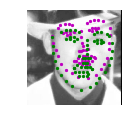

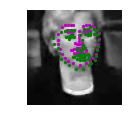

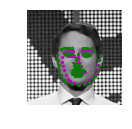

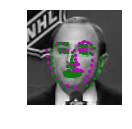

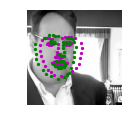

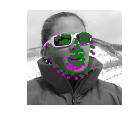

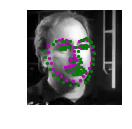

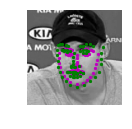

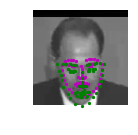

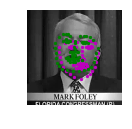

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I used  Adam optimizer because it works well with most tasks according to research especially in facial key points detection. I used the Smooth L1 loss function because it gave me better result.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: Used fewer layers and it was causing overfitting. Had to add more layers, added dropout layer and trained with gpu for faster runtime.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Number of epochs was chosen by stroke of luck and used batch size of 20 to make it as small as possible for the size of dataset.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.01086766 -0.08031565  0.09753922  0.19649164  0.23651171]
 [-0.06338121 -0.26864922 -0.00923182 -0.13370311  0.1560391 ]
 [ 0.12406243 -0.02526526 -0.19261144  0.11287089 -0.10027686]
 [-0.10725632 -0.18306321 -0.04796321  0.06135425  0.10684489]
 [ 0.02570728  0.04945354 -0.23380019 -0.19463998  0.05786724]]
(5, 5)


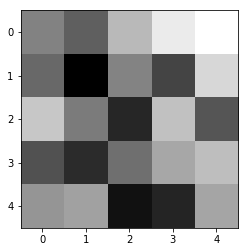

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

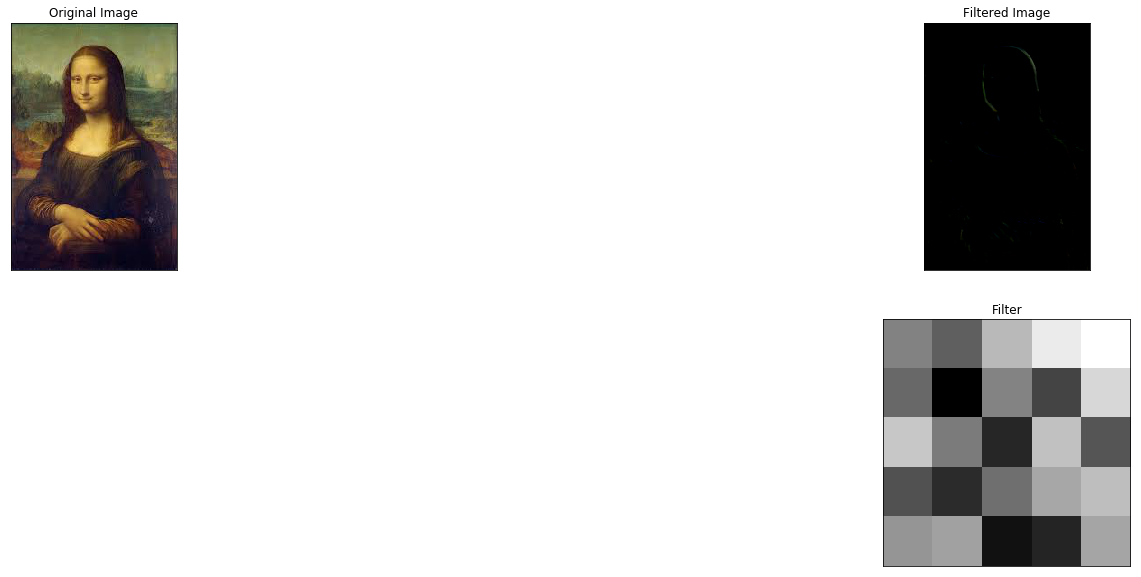

In [20]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

# Loading the image
img = cv2.imread('images/mona_lisa.jpg')

#convert colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Applying the filter to image
filtered = cv2.filter2D(img, -1, w[filter_index][0])

# Visualize the effects and the corresponding filter
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(222, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Filtered Image")

ax = fig.add_subplot(224, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')
ax.set_title("Filter")

ax = fig.add_subplot(221, xticks = [], yticks = [])
ax.imshow(img)
ax.set_title("Original Image")

plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) it detects vertical edges.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!